# Data Subsetting and Transformation Services in the Cloud

## Using NASA Earthdata Harmony

---

## Timing:
- Exercise: 45 minutes

---

## Summary

Harmony allows you to seamlessly analyze Earth observation data from different NASA data centers... 
https://harmony.earthdata.nasa.gov/

#### Benefits

- Consistent access patterns to EOSDIS holdings make cross-data center data access easier
- Data reduction services allow users to request only the data they want, in the format and projection they want
- Analysis Ready Data and cloud access will help reduce time-to-science
- Community Development helps reduce the barriers for re-use of code and sharing of domain knowledge

### Objectives

.
.
.

___

## Import Packages

In [ ]:
pip install -U harmony-py

In [ ]:
pip install -U s3fs

I also ran this on command line following xarray install instructions: http://xarray.pydata.org/en/stable/getting-started-guide/installing.html

`conda install -c conda-forge xarray dask netCDF4 bottleneck`

In [1]:
from harmony import BBox, Client, Collection, Request, LinkType
from harmony.config import Environment
import requests
from pprint import pprint
import datetime as dt
import s3fs
import xarray as xr

## Discovery service options for a given data set

In [2]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
url = f'{CMR_OPS}/{"collections"}'

response = requests.get(url, 
                        params={
                            'concept_id': 'C1940473819-POCLOUD',
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()
services = response['feed']['entry'][0]['associations']['services']
output_format = "umm_json"
service_url = "https://cmr.earthdata.nasa.gov/search/services"
for i in range(len(services)):
    response = requests.get(f"{service_url}.{output_format}?concept-id={services[i]}")
    response = response.json()
    pprint(response['items'][0]['umm']['Type'])
    pprint(response['items'][0]['umm']['ServiceOptions'])

'Harmony'
{'Subset': {'SpatialSubset': {'BoundingBox': {'AllowMultipleValues': False}},
            'TemporalSubset': {'AllowMultipleValues': False},
            'VariableSubset': {'AllowMultipleValues': True}},
 'SupportedReformattings': [{'SupportedInputFormat': 'HDF5',
                             'SupportedOutputFormats': ['NETCDF-4']},
                            {'SupportedInputFormat': 'NETCDF-4',
                             'SupportedOutputFormats': ['NETCDF-4']}]}
'OPeNDAP'
{'Subset': {'SpatialSubset': {'BoundingBox': {'AllowMultipleValues': False}},
            'TemporalSubset': {'AllowMultipleValues': False},
            'VariableSubset': {'AllowMultipleValues': True}},
 'SupportedReformattings': [{'SupportedInputFormat': 'NETCDF-4',
                             'SupportedOutputFormats': ['ASCII',
                                                        'CSV',
                                                        'NETCDF-3',
                                                

## Discover variable names

In [3]:
response = requests.get(url, 
                        params={
                            'concept_id': 'C1940473819-POCLOUD',
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()
variables = response['feed']['entry'][0]['associations']['variables']
output_format = "umm_json"
var_url = "https://cmr.earthdata.nasa.gov/search/variables"
for i in range(len(variables)):
    response = requests.get(f"{var_url}.{output_format}?concept-id={variables[i]}")
    response = response.json()
    # pprint(response['items'][0]['umm'])
    if 'Name' in response['items'][0]['umm']: pprint(response['items'][0]['umm']['Name'])

'sses_standard_deviation_4um'
'l2p_flags'
'time'
'dt_analysis'
'sses_standard_deviation'
'sst_dtime'
'sses_bias_4um'
'lat'
'sea_surface_temperature_4um'
'sses_bias'
'lon'
'sea_surface_temperature'
'quality_level'
'wind_speed'
'quality_level_4um'


In [18]:
variable = ['sea_surface_temperature']

In [5]:
# cmr_url = "https://"+"cmr.earthdata.nasa.gov"+"/search/granules.umm_json?collection_concept_id="+"C1940473819-POCLOUD"+"&sort_key=-start_date&bounding_box=-90,-45.75,90,-45"

# response = requests.get(cmr_url)

# gid=response.json()['items'][0]['meta']['concept-id']
# print(response.json()['items'][0])
# print(gid)

## Harmony-Py set up

In [6]:
harmony_client = Client()

In [7]:
request = Request(
    collection=Collection(id='MODIS_A-JPL-L2P-v2019.0'),
    spatial=BBox(60,-45.75,90,-45), # bounding box example that can be used as an alternative to shapefile input
    temporal={
        'start': dt.datetime(2021, 11, 1),
        'stop': dt.datetime(2021, 11, 2),
    },
    # variables=variables,
)

### Valid request?

In [8]:
print(f"Request valid? {request.is_valid()}")
for m in request.error_messages():
    print(" * " + m)

Request valid? True


### Submit request

In [9]:
job_id = harmony_client.submit(request)
job_id

'22574251-4661-4dce-87d3-5afb6c864d9f'

In [10]:
harmony_client.status(job_id)

{'status': 'running',
 'message': 'There were 2 collections that matched the provided short name MODIS_A-JPL-L2P-v2019.0. See https://cmr.earthdata.nasa.gov/concepts/C1940473819-POCLOUD for details on the selected collection. The version ID for the selected collection is 2019.0. To use a different collection submit a new request specifying the desired CMR concept ID instead of the collection short name.',
 'progress': 0,
 'created_at': datetime.datetime(2021, 11, 3, 19, 48, 1, 172000, tzinfo=tzlocal()),
 'updated_at': datetime.datetime(2021, 11, 3, 19, 48, 1, 172000, tzinfo=tzlocal()),
 'request': 'https://harmony.earthdata.nasa.gov/MODIS_A-JPL-L2P-v2019.0/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&subset=lat(-45.75%3A-45)&subset=lon(60%3A90)&subset=time(%222021-11-01T00%3A00%3A00%22%3A%222021-11-02T00%3A00%3A00%22)',
 'num_input_granules': 7}

In [11]:
harmony_client.wait_for_processing(job_id, show_progress=True)


 [ Processing: 100% ] |###################################################| [|]


In [12]:
data = harmony_client.result_json(job_id)
pprint(data)

{'createdAt': '2021-11-03T19:48:01.172Z',
 'jobID': '22574251-4661-4dce-87d3-5afb6c864d9f',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/stac/22574251-4661-4dce-87d3-5afb6c864d9f/',
            'rel': 'stac-catalog-json',
            'title': 'STAC catalog',
            'type': 'application/json'},
           {'bbox': [66.801, -66.443, 113.49, -44.231],
            'href': 'https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/podaac/l2-subsetter/ead9114e-1d3f-4d68-8a9a-709d9bea990b/20211101083501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc4',
            'rel': 'data',
            'temporal': {'end': '2021-11-01T08:39:58.000Z',
                         'start': '2021-11-01T08:35:01.000Z'},
            'title': '20211101083501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc4',
            'type': 'application/x-netcdf4'},
           {'bbox': [66.7, -45.7, 90, -45],
            'href': 'https://harmony.earthdata.nasa.gov/service-results/harmony-

## Direct S3

In [13]:
results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
urls = list(results)
pprint(urls)

['s3://harmony-prod-staging/public/podaac/l2-subsetter/ead9114e-1d3f-4d68-8a9a-709d9bea990b/20211101083501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/ead9114e-1d3f-4d68-8a9a-709d9bea990b/20211101084001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/ead9114e-1d3f-4d68-8a9a-709d9bea990b/20211101101501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/ead9114e-1d3f-4d68-8a9a-709d9bea990b/20211101180501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/ead9114e-1d3f-4d68-8a9a-709d9bea990b/20211101181001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/ead9114e-1d3f-4d68-8a9a-709d9bea990b/20211101194501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4',
 's3:/

In [14]:
creds = harmony_client.aws_credentials()

In [15]:
url = urls[1]
url

's3://harmony-prod-staging/public/podaac/l2-subsetter/ead9114e-1d3f-4d68-8a9a-709d9bea990b/20211101084001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4'

### Open staged zarr files with *s3fs*

We use the AWS `s3fs` package to get metadata about the zarr data store and read in the credentials we pulled from our Harmony job response:

In [16]:
netcdf_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

with netcdf_fs.open(url) as f:
        ds= xr.open_dataset(f)
        display(ds)

<xarray.Dataset>
Dimensions:                  (nj: 366, ni: 1154, time: 1)
Coordinates:
    lat                      (nj, ni, time) float32 ...
    lon                      (nj, ni, time) float32 ...
  * time                     (time) datetime64[ns] 2021-11-01T08:40:01
Dimensions without coordinates: nj, ni
Data variables:
    sea_surface_temperature  (time, nj, ni) float32 ...
    sst_dtime                (time, nj, ni) timedelta64[ns] ...
    quality_level            (time, nj, ni) float32 ...
    sses_bias                (time, nj, ni) float32 ...
    sses_standard_deviation  (time, nj, ni) float32 ...
    l2p_flags                (time, nj, ni) int16 ...
    chlorophyll_a            (time, nj, ni) float32 ...
    K_490                    (time, nj, ni) float32 ...
    wind_speed               (time, nj, ni) float32 ...
    dt_analysis              (time, nj, ni) float32 ...
Attributes: (12/50)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      MODIS Aqua L2P SST
    summary:                    Sea surface temperature retrievals produced a...
    references:                 GHRSST Data Processing Specification v2r5
    institution:                NASA/JPL/OBPG/RSMAS
    history:                    MODIS L2P created at JPL PO.DAAC\n2021-11-03 ...
    ...                         ...
    processing_level:           L2P
    cdm_data_type:              swath
    startDirection:             Ascending
    endDirection:               Ascending
    day_night_flag:             Day
    history_json:               [{"date_time": "2021-11-03T19:48:17.893420+00...

lat_var=lat
lon_var=lon


ValueError: I/O operation on closed file.

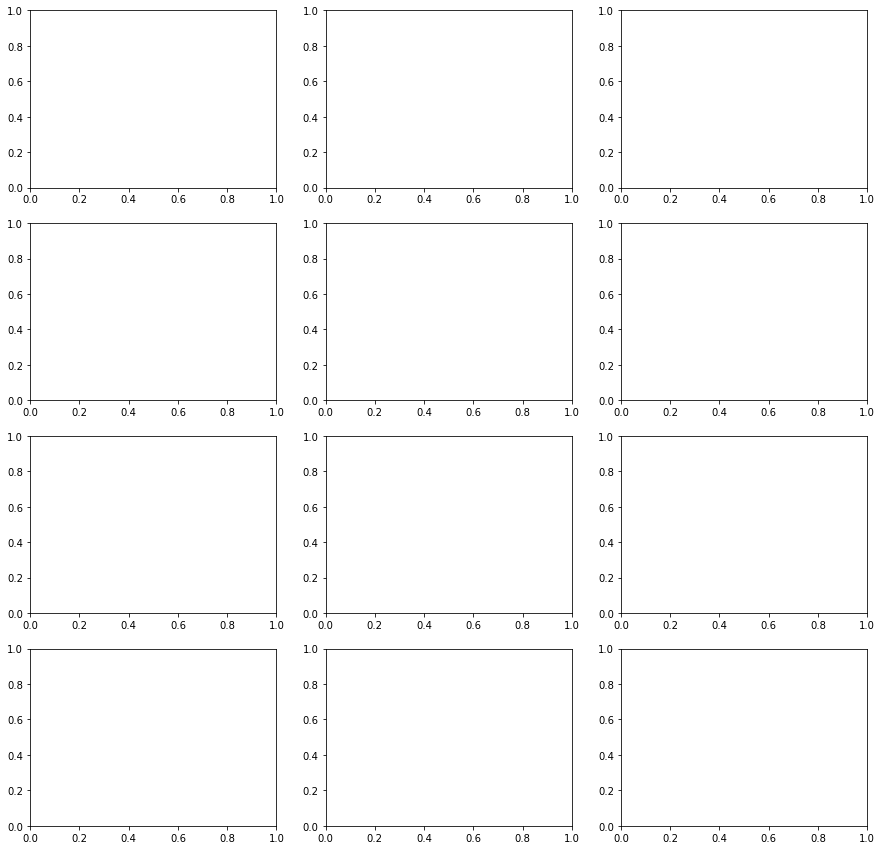

In [20]:
# Determine the lat/lon coordinate names
for coord_name, coord in ds.coords.items():
    if 'units' not in coord.attrs:
        continue
    if coord.attrs['units'] == 'degrees_north':
        lat_var = coord_name
    if coord.attrs['units'] == 'degrees_east':
        lon_var = coord_name

print(f'lat_var={lat_var}')
print(f'lon_var={lon_var}')

# if ds[variable].size == 0:
#     print("No data in subsetted region. Exiting")
#     sys.exit(0)
    
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(ncols=3, nrows=math.ceil((len(ds.data_vars)/3)))
fig.set_size_inches((15,15))

for count, xvar in enumerate(ds.data_vars):
    if  ds[xvar].dtype == "timedelta64[ns]":
        continue
        #ds[xvar].astype('timedelta64[D]').plot(ax=axes[int(count/3)][count%3])
    ds[xvar].plot(ax=axes[int(count/3)][count%3])

### Extra code attempting to read in directly from s3 into xarray:

In [ ]:
# netcdf_stores = [netcdf_fs.get_mapper(root=u, check=False) for u in urls]
# netcdf_stores

# xr.open_mfdataset(netcdf_stores)

### Trying using rioxarray

In [ ]:
# import rioxarray
# import boto3
# import rasterio as rio
# from rasterio.session import AWSSession
# import os

In [ ]:
# session = boto3.Session(aws_access_key_id=creds['aws_access_key_id'], 
#                         aws_secret_access_key=creds['aws_secret_access_key'],
#                         aws_session_token=creds['aws_session_token'],
#                         region_name='us-west-2')

In [ ]:
# rio_env = rio.Env(AWSSession(session),
#                   GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
#                   GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
#                   GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))
# rio_env.__enter__()

In [21]:
# da = rioxarray.open_rasterio(urls[1], chunks=True)
# da

### Integrate with PO.DAAC l2ss tutorial to bring in STAC items into xarray directly:

In [ ]:
# # From PO.DAAC l2ss tutorial:

# ds = xr.open_dataset('ogc_temp.nc')
# ds

# # Determine the lat/lon coordinate names
# for coord_name, coord in ds.coords.items():
#     if 'units' not in coord.attrs:
#         continue
#     if coord.attrs['units'] == 'degrees_north':
#         lat_var = coord_name
#     if coord.attrs['units'] == 'degrees_east':
#         lon_var = coord_name

# print(f'lat_var={lat_var}')
# print(f'lon_var={lon_var}')

# if ds[variable].size == 0:
#     print("No data in subsetted region. Exiting")
#     sys.exit(0)
    
# import matplotlib.pyplot as plt
# import math

# fig, axes = plt.subplots(ncols=3, nrows=math.ceil((len(ds.data_vars)/3)))
# fig.set_size_inches((15,15))

# for count, xvar in enumerate(ds.data_vars):
#     if  ds[xvar].dtype == "timedelta64[ns]":
#         continue
#         #ds[xvar].astype('timedelta64[D]').plot(ax=axes[int(count/3)][count%3])
#     ds[xvar].plot(ax=axes[int(count/3)][count%3])

In [ ]:
# # Code examples:

# # From AGU 2020 tutorial:

# smap_zarr_urls = smap_links[5:]
# smap_zarr_stores = [zarr_fs.get_mapper(root=u, check=False) for u in smap_zarr_urls]
# ds_SMAP = xr.open_mfdataset(smap_zarr_stores, engine="zarr")

# print(ds_SMAP)

### STAC workflow

In [ ]:
# stac_catalog_url = harmony_client.stac_catalog_url(job_id)
# stac_catalog_url

### Following Aaron's steps from cmr-stac tutorial:

In [ ]:
# from pystac_client import Client  

In [ ]:
# catalog = Client.open(stac_catalog_url)

In [ ]:
# links = catalog.get_links()

In [ ]:
# # links[0].to_dict()
# for link in range(len(links)): print(links[link].to_dict())

In [ ]:
# item_collection = catalog.get_all_items()

In [ ]:
# list(item_collection)

In [ ]:
# links = []

# for i in item_collection:
#         for a in i.assets:
#             links.append(i.assets[a].href)

In [ ]:
# # Trying using Harmony example code


# print(catalog.title)
# s3_links = []
# for item in catalog.get_all_items():
#     print(item.datetime, [asset.href for asset in item.assets.values()])
#     s3_links.append([asset.href for asset in item.assets.values()])

In [ ]:
## direct s3 using boto

# import boto3

# s3 = boto3.client('s3', **creds)
# for url in results:
#     bucket, obj, fn = s3_components(url)
#     with open(fn, 'wb') as f:
#         s3.download_fileobj(bucket, obj, f)

In [ ]:
# ds = xr.open_dataset('ogc_temp.nc')
# ds

# # Determine the lat/lon coordinate names
# for coord_name, coord in ds.coords.items():
#     if 'units' not in coord.attrs:
#         continue
#     if coord.attrs['units'] == 'degrees_north':
#         lat_var = coord_name
#     if coord.attrs['units'] == 'degrees_east':
#         lon_var = coord_name

# print(f'lat_var={lat_var}')
# print(f'lon_var={lon_var}')